In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
warcoder_tyre_quality_classification_path = kagglehub.dataset_download('warcoder/tyre-quality-classification')

print('Data source import complete.')


In [33]:
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten,GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras.metrics import Precision, Recall

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the root directory where the dataset is located
root_dir = '/content/kaggle/input'

# Define the classes (subdirectories in the dataset folder)
classes = ['defective', 'good']

# Loop through each class to organize data into train and test sets
for class_name in classes:
    # Define paths for train and test directories for the current class
    train_dir = os.path.join('/kaggle/working/', 'train', class_name)
    test_dir = os.path.join('/kaggle/working/', 'test', class_name)

    # Create the train and test directories if they do not already exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # List all images in the current class directory
    # If the path is incorrect, this line will throw a FileNotFoundError
    images = os.listdir(os.path.join(root_dir, class_name))

    # Split the images into training (80%) and testing (20%) sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Copy the training images to the train directory
    for img in train_images:
        source_path = os.path.join(root_dir, class_name, img)  # Path of the source image
        destination_path = os.path.join(train_dir)  # Target directory for training images
        shutil.copy(source_path, destination_path)  # Copy image from source to destination

    # Copy the testing images to the test directory
    for img in test_images:
        source_path = os.path.join(root_dir, class_name, img)  # Path of the source image
        destination_path = os.path.join(test_dir)  # Target directory for testing images
        shutil.copy(source_path, destination_path)  # Copy image from source to destination


In [8]:
generator=ImageDataGenerator(rescale=1.0/255.0,
      rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

train_generator=generator.flow_from_directory("/kaggle/working/train",class_mode="binary",
                                            batch_size=64,target_size=(224,224))
test_generator=generator.flow_from_directory("/kaggle/working/test",class_mode="binary",
                                           batch_size=64,target_size=(224,224))

Found 1484 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


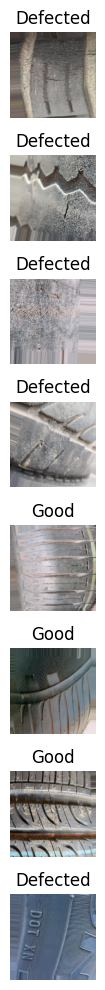

In [9]:
images, labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(len(images)//8):
    plt.subplot(8,1,i+1)
    plt.imshow(images[i])
    if labels[i] ==0:
        plt.title('Defected')
    else:
        plt.title('Good')
    plt.axis('off')

plt.tight_layout()  # Adjust layout
plt.show()

In [10]:
def bar_plot(directory):
    classes=os.listdir(directory)
    class_counts={class_name:0 for class_name in classes}
    for class_name in classes:
        class_dir=os.path.join(directory,class_name)
        class_counts[class_name]=len(os.listdir(class_dir))
    plt.figure()
    plt.bar(class_counts.keys(),class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Bar Plot of Classes in '+ directory)
    plt.show()

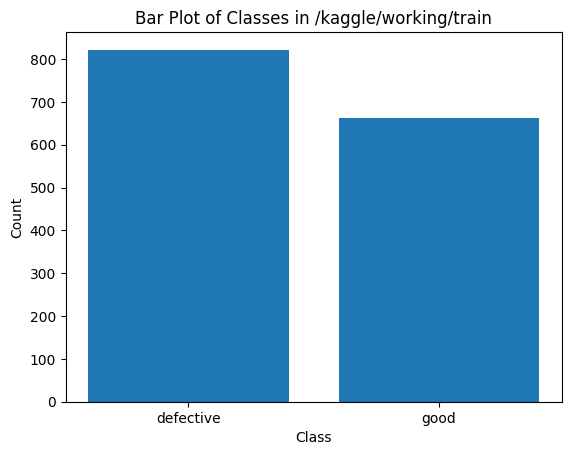

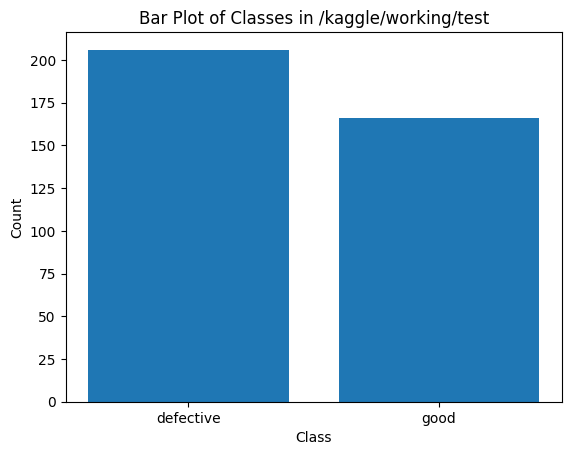

In [11]:
train_dir='/kaggle/working/train'
test_dir='/kaggle/working/test'
bar_plot(train_dir)
bar_plot(test_dir)

In [12]:
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#layer_1= base_model.output
#layer_2 = GlobalAveragePooling2D()(layer_1)
#layer_3= Dense(64, activation='relu')(layer_2)
#layer_4=Dense(32,activation='relu')(layer_3)
#predictions = Dense(1, activation='sigmoid')(layer_4)
#model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,720,961 (90.49 MB)

 Trainable params: 133,249 (520.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Precision(),Recall()])
#history=model.fit(train_generator,validation_data=test_generator,epochs=15,batch_size=32,verbose=1)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.5823 - loss: 0.6706 - precision: 0.5876 - recall: 0.3013 - val_accuracy: 0.5995 - val_loss: 0.6764 - val_precision: 0.6604 - val_recall: 0.2108
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.6420 - loss: 0.6329 - precision: 0.7239 - recall: 0.3679 - val_accuracy: 0.5645 - val_loss: 0.6813 - val_precision: 0.5141 - val_recall: 0.4398
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.6677 - loss: 0.6178 - precision: 0.7242 - recall: 0.4098 - val_accuracy: 0.6210 - val_loss: 0.6714 - val_precision: 0.7049 - val_recall: 0.2590
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6714 - loss: 0.6056 - precision: 0.7836 - recall: 0.3792 - val_accuracy: 0.6102 - val_loss: 0.6594 - val_precision: 0.6615 - val_recall: 0.2590
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.6662 - loss: 0.6159 - precision: 0.7267 - recall: 0.3936 - val_accuracy: 0.6048 - val_loss: 0.6725 - val_precis

In [14]:
#model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5999 - loss: 0.6545 - precision: 0.5294 - recall: 0.7800


[0.6418315768241882,
 0.6263440847396851,
 0.5574468374252319,
 0.7891566157341003]

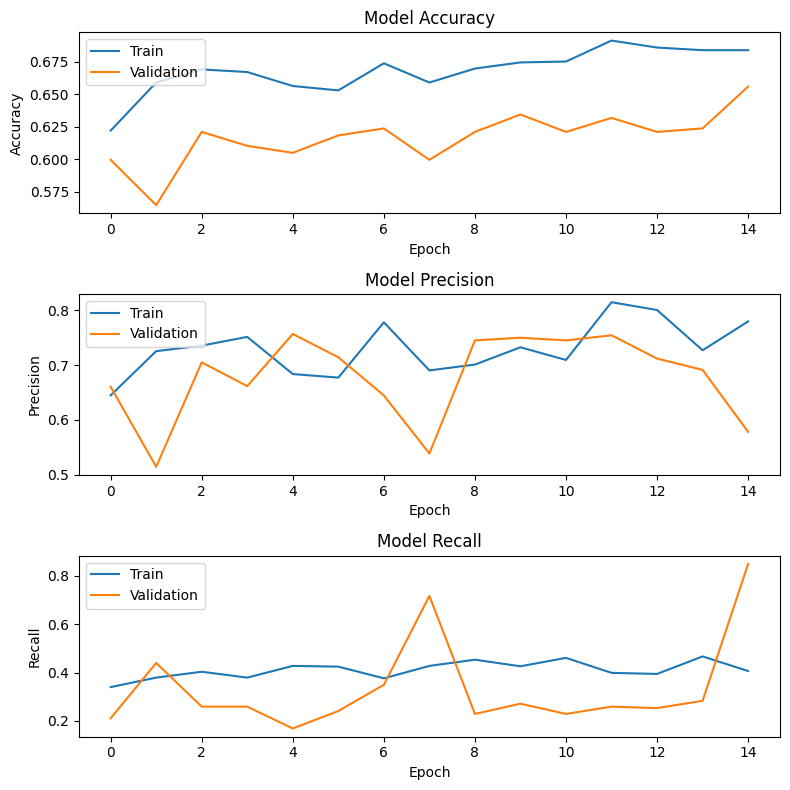

In [15]:
#plt.figure(figsize=(8,8))
#plt.subplot(3, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(3, 1, 2)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(3, 1, 3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

---

### Transfer Learning of a MobileNet model

In [25]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall

# Define input shape (example: 224x224 RGB images)
input_shape = (224, 224, 3)

# Load MobileNetV1 model with specified input shape, without the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)                     # Add MobileNet as the base
model.add(Flatten())                      # Flatten the output of the base model
model.add(Dense(64, activation='relu'))   # Add dense layers
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Train the model (ensure train_generator and test_generator are defined properly)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    batch_size=32,
    verbose=1
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.6041 - loss: 2.6965 - precision_3: 0.5691 - recall_3: 0.5139 - val_accuracy: 0.8710 - val_loss: 0.5262 - val_precision_3: 0.8278 - val_recall_3: 0.8976
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8750 - loss: 0.4366 - precision_3: 0.8497 - recall_3: 0.8963 - val_accuracy: 0.8522 - val_loss: 0.4961 - val_precision_3: 0.9302 - val_recall_3: 0.7229
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8942 - loss: 0.2360 - precision_3: 0.8811 - recall_3: 0.8832 - val_accuracy: 0.8710 - val_loss: 0.3190 - val_precision_3: 0.7950 - val_recall_3: 0.9578
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9104 - loss: 0.2075 - precision_3: 0.8792 - recall_3: 0.9244 - val_accuracy: 0.8656 - val_loss: 0.3544 - val_precision_3: 0.9394 - val_recall_3: 0.7470
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9379 - loss: 0.1545 - precision_3: 0.9438 - recall_3: 0.9206 - val_a

In [26]:
model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8908 - loss: 0.3160 - precision_3: 0.9139 - recall_3: 0.8425


[0.23053818941116333,
 0.9139785170555115,
 0.9240506291389465,
 0.8795180916786194]

In [27]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision_3', 'recall_3', 'val_accuracy', 'val_loss', 'val_precision_3', 'val_recall_3'])


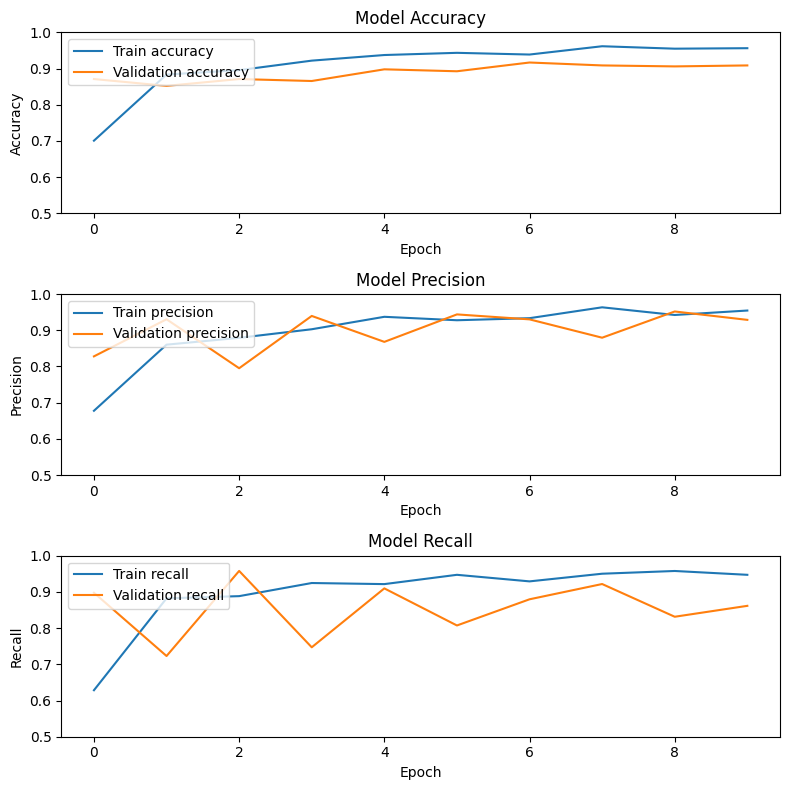

In [31]:
import matplotlib.pyplot as plt

# Get the available keys in history
history_keys = history.history.keys()

# Map the metrics dynamically
metric_mapping = {
    'accuracy': ('accuracy', 'val_accuracy'),
    'precision': ('precision_3', 'val_precision_3'),
    'recall': ('recall_3', 'val_recall_3'),
}

# Function to plot the metrics
def plot_metric(metric_name, metric_key, val_metric_key):
    plt.plot(history.history[metric_key], label=f'Train {metric_name}')
    plt.plot(history.history[val_metric_key], label=f'Validation {metric_name}')
    plt.title(f'Model {metric_name.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend(loc='upper left')
    plt.ylim(0.5, 1)  # Set the y-axis range from 0.5 to 1

# Plotting training metrics
plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(3, 1, 1)
plot_metric('accuracy', *metric_mapping['accuracy'])

# Precision plot
plt.subplot(3, 1, 2)
plot_metric('precision', *metric_mapping['precision'])

# Recall plot
plt.subplot(3, 1, 3)
plot_metric('recall', *metric_mapping['recall'])

# Adjust layout and display plots
plt.tight_layout()
plt.show()


### Make prediction on a new image

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to the new image
image_path = '/content/good (820).jpg'

# Load the image and preprocess it
img = load_img(image_path, target_size=(224, 224))  # Resize image to match model input
img_array = img_to_array(img)                      # Convert image to numpy array
img_array = img_array / 255.0                      # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension

# Predict the class
prediction = model.predict(img_array)[0][0]        # Extract prediction score

# Interpret the result
threshold = 0.5  # Define a threshold for classification
if prediction > threshold:
    print(f"The image is classified as 'good' with a confidence of {prediction:.2f}.")
else:
    print(f"The image is classified as 'defective' with a confidence of {1 - prediction:.2f}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
The image is classified as 'good' with a confidence of 0.99.


### Saving the model

In [35]:
# Save the entire model (architecture + weights + optimizer state)
model.save('MobileNetTyre.keras')


In [2]:
# Load the model back
from tensorflow.keras.models import load_model
model = load_model('/content/MobileNetTyre.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
